# 1. Introduction

## 1.1. Glaucoma Detection with a Deep Learning Model Using Fundus Images

Glaucoma is a group of eye conditions that damage the optic nerve, which is crucial for maintaining good vision. This damage is often a result of abnormally high pressure in the eye. It is one of the leading causes of blindness in individuals over the age of 60.

---
In this project, we aim to leverage the power of Deep Learning to detect Glaucoma using fundus images. Fundus images are photographs of the interior surface of the eye and include structures such as the retina, optic disc, macula, and posterior pole (back of the eye). These images provide a wealth of information and are commonly used in diagnosing various eye diseases, including Glaucoma.

# 2. Libraries

In [1]:
! pip install monai==1.3.0

  Obtaining dependency information for monai==1.3.0 from https://files.pythonhosted.org/packages/08/94/e8a7ba00dd0c7ce959648b562043bd22125d65f5e519e566c822f71bc437/monai-1.3.0-202310121228-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00


In [2]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2

from typing import List, Tuple, Dict, Union, Callable, Iterable

## 2.1. Deterministic Code

The next cell is designed to make your **Python, PyTorch, and MONAI** code **deterministic**, which means it will produce the same output given the same input. This is achieved by setting a specific seed for the random number generators in Python's random module, numpy, PyTorch, and MONAI. The function `make_deterministic(seed)` takes an integer `seed` as input and sets this seed for all the mentioned libraries. This ensures that any random number generation they perform will be consistent across multiple runs, which is crucial for reproducibility in experiments.

* **Deterministic Code**: Deterministic code, given the same input, will always produce the same output. This is crucial for reproducibility in experiments.
* **make_deterministic Function**: The function `make_deterministic(seed)` sets a specific seed for the random number generators in Python's random module, numpy, PyTorch, and MONAI. This ensures that any random number generation they perform will be consistent across multiple runs.

---

The second part of the code introduces a decorator `deterministic(func)`. A decorator in Python is a function that wraps another function to extend its behavior without explicitly modifying it. In this case, the `deterministic` decorator wraps around your function (denoted as `func`). Before your function is executed, it calls `make_deterministic(seed=random_seed)` to set the seed. If a `random_seed` is provided in the function arguments, it will use that; otherwise, it defaults to 0. By using this decorator with your function, like `@deterministic`, you ensure that the code inside your function is deterministic. However, remember that this does not guarantee complete determinism due to factors outside of these libraries' control.

* **Decorator**: A decorator in Python is a function that wraps another function to extend its behavior without explicitly modifying it.
* **deterministic Function**: The `deterministic(func)` decorator wraps around your function (denoted as `func`). Before your function is executed, it calls `make_deterministic(seed=random_seed)` to set the seed.


In [3]:
import random
import numpy as np
import torch
from monai.utils import set_determinism

def make_deterministic(seed):
    """
    Make the code deterministic using the specified seed for Python, PyTorch, and MONAI.
    
    Args:
        seed (int): The seed to use for random number generation.
    """
    # The seed for Python's random module
    random.seed(seed)
    
    # The seed for numpy
    np.random.seed(seed)
    
    # The seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # The seed for MONAI
    set_determinism(seed=seed)
    
def deterministic(func):
    """
    A decorator that makes a function deterministic.
    """
    def wrapper(*args, **kwargs):
        if 'random_seed' in kwargs:
            random_seed = kwargs['random_seed']
        else:
            random_seed = 0
        make_deterministic(seed=random_seed)
        return func(*args, **kwargs)
    return wrapper

## 2.2. Setting the Device: CPU or GPU?

A **CPU (Central Processing Unit)** and a **GPU (Graphics Processing Unit)** can be compared to a manager and a team of workers, respectively. 

- The **CPU**, like a manager, is great at handling a variety of tasks. It can quickly switch between tasks and handle complex operations. However, it has a limited number of cores (workers), so when it comes to very large tasks, such as processing high-resolution images or training complex deep learning models, it might take a long time to finish.

- On the other hand, a **GPU**, like a team of workers, excels at doing the same operation over and over again quickly. It has a lot more cores than a CPU. So, when a big project comes in, like processing a high-resolution image or running a complex machine learning model, the GPU can split the task among its many cores and finish the job much faster than a CPU.

In the context of image deep learning, setting the device to `cuda` means that you are choosing to use the GPU for computations, if one is available. Deep learning involves a lot of matrix operations (like multiplication and addition), which are highly parallelizable, and a GPU with its hundreds of cores can do these operations much faster than a CPU. This is especially true for image data, which usually involves high-dimensional matrices. Therefore, using `cuda` can significantly speed up the training and inference times of our deep learning models.

In [4]:
# Selecting the processor device. Making sure our accelerator is set to GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}")

Device is: cuda


# 3. Dataset

In [5]:
meta = pd.read_csv("/kaggle/input/glaucoma-detection/glaucoma.csv")
meta.head()

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


In [6]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Filename  650 non-null    object 
 1   ExpCDR    650 non-null    float64
 2   Eye       650 non-null    object 
 3   Set       650 non-null    object 
 4   Glaucoma  650 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 25.5+ KB


In [7]:
# Distribution of diagnosis in our dataset: 0: Normal, 1: Glaucoma
meta["Glaucoma"].value_counts()

Glaucoma
0    482
1    168
Name: count, dtype: int64

In [8]:
img_root = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
mask_root = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Semi-automatic-annotations"

# Adding image and mask roots to the dataframe
meta["Image Path"] = meta["Filename"].apply(lambda fn: os.path.join(img_root, fn))
meta["Mask Path"] = meta["Filename"].apply(lambda fn: os.path.join(mask_root, f"{fn.split('.')[0]}.mat"))
meta.head()

,Filename,ExpCDR,Eye,Set,Glaucoma,Image Path,Mask Path
0,001.jpg,0.7097,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
1,002.jpg,0.6953,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
2,003.jpg,0.9629,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
3,004.jpg,0.7246,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
4,005.jpg,0.6138,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...


### 3.1. Exploring Image Data

In [9]:
def remove_black_padding(img, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(cnt)
    
    p = 30
    crop = img[y-p:y+h+p, x-p:x+w+p]
    crop = cv2.resize(crop, (400, 300))
    return crop

In [10]:
def get_subject_images(row):
    original_image = cv2.imread(row["Image Path"])

    # Loading mask from .mat file and extract numpy array of the mask, then make it one class
    mat = scipy.io.loadmat(row["Mask Path"])
    binary_mask = (mat['mask'] > 0).astype(np.uint8)
    mask = cv2.cvtColor(binary_mask*255, cv2.COLOR_GRAY2RGB)

    # Apply mask to the original image
    if mask.size != original_image.size:
        shape = original_image.shape
        mask = cv2.resize(mask, (shape[1], shape[0]))
        
    masked = original_image * (mask > 0)

    # Remove Black Padding
    removed_padding = remove_black_padding(original_image, binary_mask)
    
    all_images = {
        "Original Image": original_image,
        "Mask": mask,
        "Masked Image": masked,
        "Removed Padding": removed_padding
    }
    
    return all_images

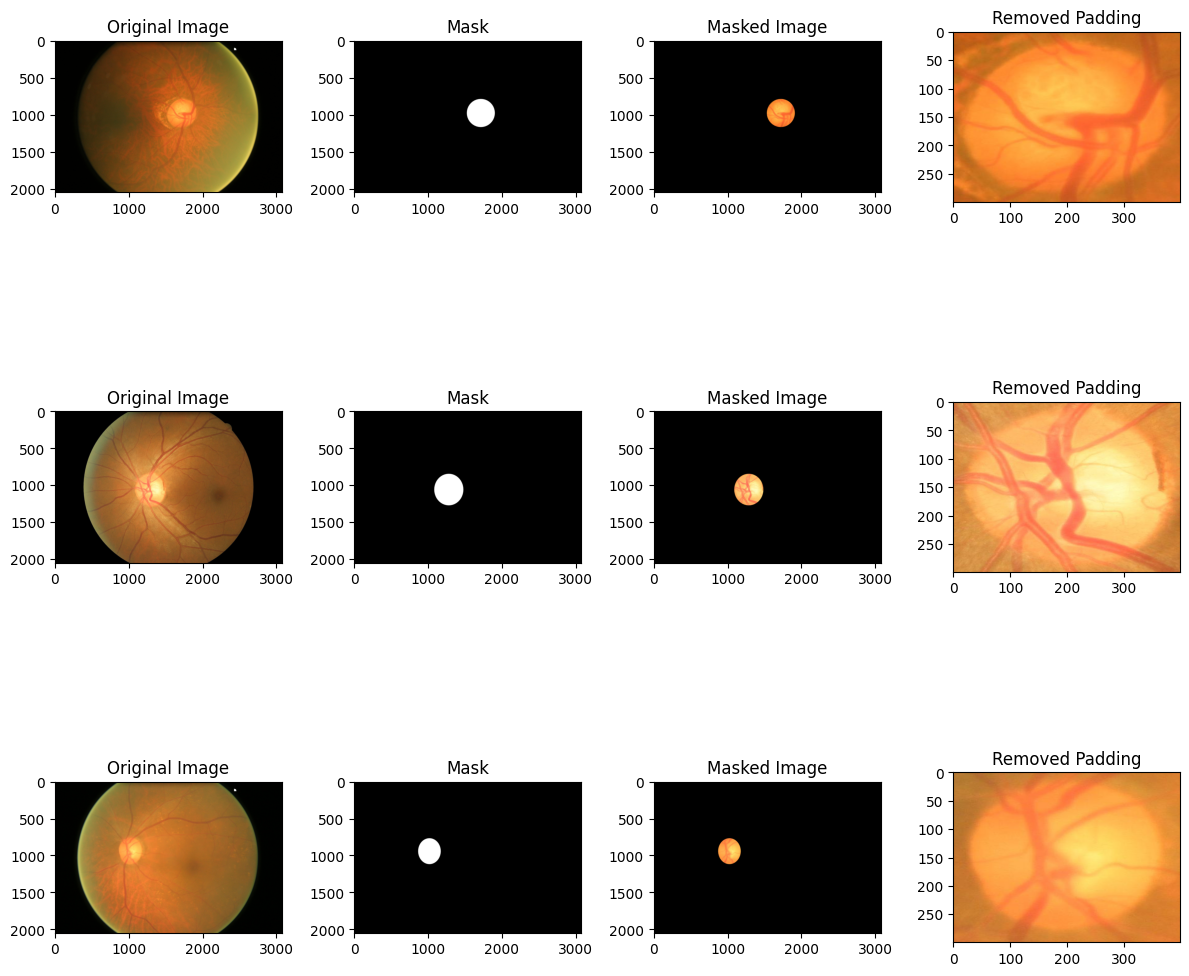

In [11]:
import scipy.io

@deterministic
def visualize_images(num_subjects=3):
    num_cols = 4
    fig, axs = plt.subplots(num_subjects, num_cols, figsize=(num_cols*3, num_cols*num_subjects))
    
    for i, row in meta.sample(n=num_subjects).reset_index().iterrows():
        all_images = get_subject_images(row)
        for j, (title, image) in enumerate(all_images.items()):
            axs[i, j].imshow(image[..., ::-1])
            axs[i, j].set_title(title)

    plt.tight_layout()
    plt.show()
    
visualize_images(num_subjects=3)

### 3.2. Save Masked and Cropped Images

In [12]:
from tqdm.notebook import tqdm

save_root = "/kaggle/working/masked-images"
os.makedirs(save_root, exist_ok=True)

for i, row in tqdm(meta.iterrows(), total=len(meta)):
    all_images = get_subject_images(row)
    
    new_root = os.path.join(save_root, f"{row['Filename']}")
    cv2.imwrite(new_root, all_images["Removed Padding"])
    meta.at[i, "Cropped Path"] = new_root

  0%|          | 0/650 [00:00<?, ?it/s]

### Building datasets and data loaders

In [13]:
from monai.transforms import (LoadImageD, EnsureChannelFirstD, ResizeD, Compose,
                              NormalizeIntensityD, RandRotateD, RandZoomD,
                              LambdaD, ToTensorD, RepeatChannelD,
                              Rotate90d, SelectItemsd)
from monai.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [14]:
class GlaucomaDataset(Dataset):
    """
    A PyTorch Dataset class for the Glaucoma dataset.
    """

    def __init__(self, df, transform):
        """
        Initialize the dataset.

        Args:
            df (pandas.DataFrame): The dataframe containing the data.
            transform (callable): The transformations to apply to the data.
        """
        self.df = df
        self.transform = transform
        self.data = self.get_data()
    
    def get_data(self):
        """
        Extract the data from the dataframe.

        Returns:
            list: A list of tuples where each tuple contains the path to an image and its corresponding label.
        """
        data = []
        for i, row in self.df.iterrows():
            label = row["Glaucoma"]
            path = row["Cropped Path"]
            data.append((path, label))
        return data
    
    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Get a sample from the dataset and apply monai tranformations to it.

        Args:
            idx (int): The index of the sample to get.

        Returns:
            dict: A dictionary containing the image and its corresponding label.
        """
        image_path, label = self.data[idx]
        item_dict = {"image": image_path, "label": label}
        return self.transform(item_dict)

## 3.3 Glaucoma Dataset using `monai.transforms`
#### The transforms are applied to the fundus images for both training and testing datasets. 

The `aug_transforms` are applied to the training data for data augmentation, which helps the model generalize better. The `no_aug_transforms` (without random zooming) are applied to the testing data to evaluate the model's performance on new, unseen data.

---
>**NOTE:** Data augmentation is used on the training set to increase its diversity and help the model generalize better. However, the test set should represent real-world data that the model will encounter in production. Applying augmentation to the test set would mean testing the model on artificially created data, not on real-world data. This could give a misleading measure of the model's performance. Therefore, we typically only apply data augmentation to the training set, not the test set.
---


In [15]:
image_size = 224

# Building MONAI transforms
aug_transforms = Compose([
          LoadImageD(keys="image"),
          EnsureChannelFirstD(keys="image"),
          # LambdaD(keys="image", func=lambda x: x[0, :, :].unsqueeze(0) if x.ndim==3 else x),
          ResizeD(keys="image", spatial_size=(image_size, image_size)),
          NormalizeIntensityD(keys="image"),
          RandRotateD(keys="image", mode="bilinear", range_x=0.26, prob=0.5),
          RandZoomD(keys="image", mode="bilinear"),
          ToTensorD(keys=["image", "label"]),
          SelectItemsd(keys=["image", "label"])
        ])

no_aug_transforms = Compose([
          LoadImageD(keys="image"),
          EnsureChannelFirstD(keys="image"),
          # LambdaD(keys="image", func=lambda x: x[0, :, :].unsqueeze(0) if x.ndim==3 else x),
          ResizeD(keys="image", spatial_size=(image_size, image_size)),
          NormalizeIntensityD(keys="image"),
          ToTensorD(keys=["image", "label"]),
          SelectItemsd(keys=["image", "label"])
          ])

## 3.4. Concepts

In PyTorch, a `DataLoader` is used to load the data in a convenient format that makes it easy to feed into a model for training or testing. Here's what each parameter does:

- `train_data` and `test_data`: These are instances of a Dataset class which you have defined. They should implement the `__len__` method, which returns the number of items in the dataset, and the `__getitem__` method, which returns the item (such as an image and its label) at a given index.

- `batch_size=bs`: This determines the number of samples per batch. This is often set to a power of 2, such as 4, 8, 16, etc., to take full advantage of hardware. The batch size can affect the model's performance and the speed of training.

- `shuffle=True` or `shuffle=False`: This determines whether to shuffle the data at every epoch for the training set (`shuffle=True`) or not for the test set (`shuffle=False`). Shuffling the training data is good practice as it removes correlation between batches and helps the model generalize better.

- `drop_last=True`: This is used when the dataset size is not a multiple of the batch size. If `True`, it drops the last non-full batch of each worker's dataset replica. For example, if the batch size is 64 and the dataset has 1000 images, it will drop the last batch of 16 images. This is typically set to `True` for training data to ensure that all batches have the same size, but it's not necessary for the test data.


In [16]:
@deterministic
def build_dataloaders():
    meta_nl = meta.loc[meta["Glaucoma"] == 0]
    meta_gl = meta.loc[meta["Glaucoma"] == 1]
    new_meta = pd.concat([meta_nl.sample(n=len(meta_gl)), meta_gl]).copy()
    
    train_df, test_df = train_test_split(new_meta, test_size=0.25)
    
    train_data = GlaucomaDataset(train_df, aug_transforms)
    test_data = GlaucomaDataset(test_df, no_aug_transforms)
    
    idx = 0
    sample = train_data[idx]
    print(f"Image Shape: {sample['image'].shape} | Label: {sample['label']}\n")

    bs = 8
    train_dl = DataLoader(train_data, batch_size=bs, shuffle=True, drop_last=True)
    test_dl = DataLoader(test_data, batch_size=bs, shuffle=False)
    
    return train_dl, test_dl
    
train_dl, test_dl = build_dataloaders()

sample_batch = next(iter((train_dl)))
print(f"batch['image'] shape: {sample_batch['image'].shape}")
print(f"batch['image'] dtype: {sample_batch['image'].dtype}")
print(f"batch['label'] shape: {sample_batch['label'].shape}")
print(f"batch['label'] dtype: {sample_batch['label'].dtype}")

Image Shape: torch.Size([3, 224, 224]) | Label: 0

batch['image'] shape: torch.Size([8, 3, 224, 224])
batch['image'] dtype: torch.float32
batch['label'] shape: torch.Size([8])
batch['label'] dtype: torch.int64


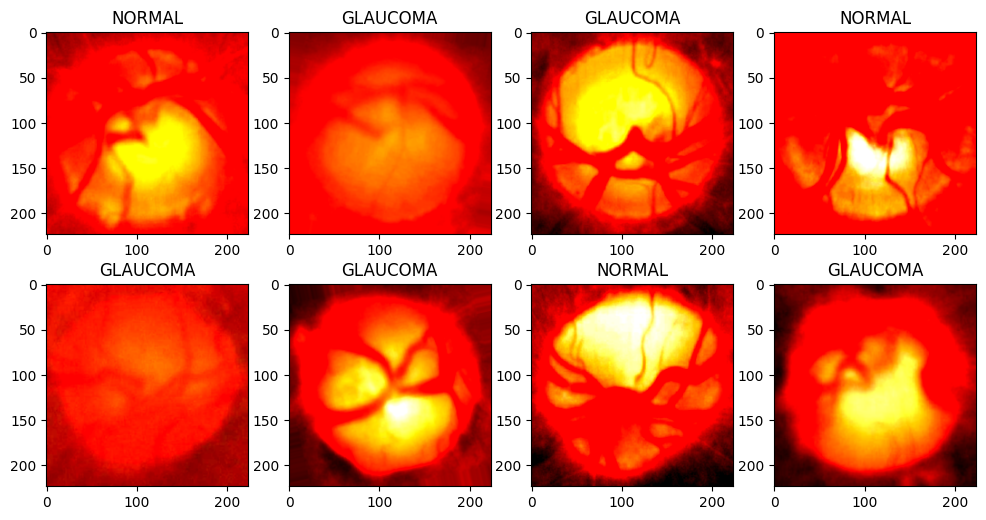

In [17]:
# Plotting sample images from the dataloaders.

@deterministic
def plot_sample_dataloader_images(dataloader):
    """
    Plot 9 sample images from either the training or test dataloaders.
    """
    label_tensor_dict = {1:'GLAUCOMA', 0:'NORMAL'}
    dataiter = iter(dataloader)
    image_tensor_list = list()
    label_list = list()
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    data = next(dataiter)
    image_batch, label_batch = data['image'], data['label']
    for i in range(8):
        axes[i//4, i%4].imshow(image_batch[i].permute(1, 2, 0))
        axes[i//4, i%4].set_title(label_tensor_dict[int(label_batch[i])])
    plt.show()

plot_sample_dataloader_images(train_dl)

# 4. Deep Learning Model

In [18]:
# Import necessary libraries
import torchvision.models as models
import torch.nn as nn
import shutil

@deterministic
def build_model(arch = 'vgg16', pretrained = False):
    """
    Build a resnet model using Pytorch.
    Parameters:
        - arch (str): baseline architecture of the model that could be called using
        torchvision.models.arch command.
        - pretrained (bool): whether or not to use pretrained weights.
    """

    # Loading a model with the specified architecture from torch
    
    if 'vgg' not in arch and 'alexnet' not in arch and 'resnet' not in arch:
        raise ValueError('Only resnet, vgg or alexnet models can be loaded!')
    else:
        try:
            model = eval(f'models.{arch}(pretrained={pretrained})')
        except:
            raise ValueError('The name of the architecture is not valid!')

    # Replacing the final fully connected layer of the model
    # We have two classes, and therefore, the final FC layer will have two final nodes
    # The VGG network has no FC layer, so we directly change its final layer
    if 'vgg' in arch or 'alexnet' in arch:
        model.classifier._modules['6'] = nn.Linear(4096, 2)
    else:
        num_in_features = model.fc.in_features
        model.fc = nn.Linear(num_in_features, 2)

    return model

In [19]:
! pip install torchsummary

In [20]:
from torchsummary import summary

# Plotting the structure for a Vgg16 model
non_trained_vgg16 = build_model(arch='vgg16', pretrained=False).to(device)
summary(non_trained_vgg16, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# 5. Training

## 5.1. Concepts

### 5.1.1. Criterion (Loss Function)
The `criterion` in PyTorch is another name for the loss function. It's a method of evaluating how well specific algorithm models the given data. If predictions deviate too much from actual results, loss function would cough up a very large number. Common loss functions include:
- Mean Squared Error (MSE)
- Cross Entropy Loss
- Negative Log Likelihood (NLL)

### 5.1.2 Learning Rate
The `learning rate` is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. It is usually represented as:
$$\theta = \theta - \eta . \nabla_\theta J( \theta)$$
where $\theta$ represents the parameters, $\eta$ is the learning rate and $\nabla_\theta J( \theta)$ is the gradient of the loss function $J( \theta)$ with respect to the parameters.

### 5.1.3 Optimizer
The `optimizer` in PyTorch is an implementation of a specific optimization algorithm which is used to update the parameters of the model (weights and biases). Common optimizers include:
- Stochastic Gradient Descent (SGD)
- Adam
- RMSProp

### 5.1.4. Training Epoch
An `epoch` is one complete pass through the entire training dataset. The number of epochs is a hyperparameter that defines the number of times the learning algorithm will work through the entire training dataset.

### 5.1.5. Accuracy
`Accuracy` is one of the metrics for evaluating prediction performance. In the context of classification, it's the ratio of the number of correct predictions to the total number of input samples.

#### 5.1.6. Model Eval and Model Train
In PyTorch, `model.train()` and `model.eval()` are used to switch between training and evaluation modes. When `model.train()` is called, the model is set to training mode. This activates the gradients, enabling backpropagation and parameter updates during optimization. It also activates regularization techniques like Dropout and Batch Normalization, which behave differently during training and evaluation. Dropout randomly zeroes some of the layer's outputs to prevent overfitting, and Batch Normalization normalizes layer inputs to maintain stable learning. When `model.eval()` is called, the model is set to evaluation mode, deactivating gradients and the aforementioned regularization techniques. This ensures the model produces more deterministic results during evaluation, which is essential for model assessment.


### 5.1.7. Loss.backward and Gradient Descent
`loss.backward()` computes the gradient of the loss with respect to the parameters (or anything requiring gradients) using backpropagation. `Gradient Descent` is an optimization algorithm used to minimize some function (here, the loss) by iteratively moving in the direction of steepest descent as defined by the negative of the gradient.

### 5.1.8. Optimizer.step
`optimizer.step` performs a parameter update based on the current gradient (stored in `.grad` attribute of a parameter).

### 5.1.9. Zero Grads
`optimizer.zero_grad` is used to zero out the gradients at the start of a new minibatch. By default, gradients in PyTorch are accumulated, so we need to explicitly zero them out.

### 5.1.10. Transfer to Device
`model.to(device)` is used to move the model parameters to the appropriate compute device (CPU or GPU) for computation.

### 5.1.11. Looping Over Train or Test Loader
Looping over a train or test loader allows us to access batches of data from the dataset. This is done in the training and validation loops.


In [21]:
def train_classifier(model: torch.nn.Module,
                     model_name: str,
                     train_loader: Iterable,
                     valid_loader: Iterable,
                     criterion: Callable,
                     optimizer: torch.optim,
                     num_epochs: int,
                     plot_curves: bool):
    """
    Train a classifier model using pytorch and the given parameters.
    Parameters:
    model (Callable): any pytorch module,
    model_name (str): name of the model to be saved.
    train_loader (Iterable): dataloader for training data,
    valid_loader (Iterable): dataloader for validation data,
    criterion (Callable): any loss function,
    optimizer (torch.optim): a pytorch optimizer,
    num_epochs (int): number of epochs to train the model,
    plot_charts (bool): whether or not to plot the training and validation loss
    and accuracy curves.
    """

    # Sending the model to device (preferably GPU)
    model.to(device)

    # Releasing the GPU memory. This is not necessary, but a good practice to do
    # before starting new training sessions.
    with torch.no_grad():
        torch.cuda.empty_cache()

    # Building a saving directory for models
    model_save_dir = os.path.join('Best_Models', model_name)
    if os.path.exists(model_save_dir):
        shutil.rmtree(model_save_dir)
        
    os.makedirs(model_save_dir, exist_ok=True)

    # lists to log the epoch values
    epoch_train_loss_list = list()
    epoch_train_accuracy_list = list()
    epoch_valid_loss_list = list()
    epoch_valid_accuracy_list = list()

    # Starting the training loop
    for epoch in range(1, num_epochs+1):
        print("-" * 20, f'\nStarting epoch: {epoch}/{num_epochs}')

        ## training
        model.train()
        steps_train_loss = 0.0
        steps_correct_predictions = 0

        for batch in tqdm(train_loader, unit="batch"):
            inputs, labels = batch['image'].to(device), batch['label'].to(device)
            
            ### Zero the parameter gradients
            optimizer.zero_grad()

            ### Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            ### Accumulating the loss and number of correct predictions in step
            steps_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            steps_correct_predictions += (predicted == labels).sum().item()

        ## Measuring the epoch training loss and accuracy
        epoch_train_loss = steps_train_loss/ len(train_loader)
        epoch_train_loss_list.append(epoch_train_loss)
        epoch_train_accuracy = steps_correct_predictions / len(train_loader.dataset)
        epoch_train_accuracy_list.append(epoch_train_accuracy)

        ## validation
        model.eval()
        steps_valid_loss = 0.0
        steps_correct_predictions = 0

        for batch in tqdm(valid_loader, unit="batch"):
            inputs, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            ### Accumulating the loss and number of correct predictions in step
            steps_valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            steps_correct_predictions += (predicted == labels).sum().item()

        ## Measuring the epoch validation loss and accuracy
        epoch_valid_loss = steps_valid_loss/ len(valid_loader)
        epoch_valid_loss_list.append(epoch_valid_loss)
        epoch_valid_accuracy = steps_correct_predictions / len(valid_loader.dataset)
        epoch_valid_accuracy_list.append(epoch_valid_accuracy)

        ## Printing the logs
        print(f'train loss: {epoch_train_loss:.2f} | \
        train accuracy: {epoch_train_accuracy:.2f}')
        print(f'valid loss: {epoch_valid_loss:.2f} | \
        valid accuracy: {epoch_valid_accuracy:.2f}')

        ## Saving the best model
        if epoch==1:
            best_valid_loss = epoch_valid_loss
            weight_name = f'{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth'
            torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
        elif epoch_valid_loss < best_valid_loss:
            weight_name = f'{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth'
            torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
            best_valid_loss = epoch_valid_loss

    # Printing the best model
    print(f'\nTraining was over. The best model was: {weight_name}')

    # Plotting the loss and accuracy curves
    if plot_curves:
        epoch_train_loss_list.insert(0, 0)
        epoch_train_accuracy_list.insert(0, 0)
        epoch_valid_loss_list.insert(0, 0)
        epoch_valid_accuracy_list.insert(0, 0)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].plot(epoch_train_loss_list, color='blue', label='training')
        axes[0].plot(epoch_valid_loss_list, color='orange', label='validation')
        axes[0].set_xlim(1, len(epoch_valid_loss_list)+1)
        axes[0].set_title('Loss curves')
        axes[0].legend()
        axes[1].plot(epoch_train_accuracy_list, color='blue', label='training')
        axes[1].plot(epoch_valid_accuracy_list, color='orange', label='validation')
        axes[1].set_xlim(1, len(epoch_train_accuracy_list)+1)
        axes[1].set_title('Accuracy curves')
        axes[1].legend();

    # Loading the best weights and returning the model
    model.load_state_dict(torch.load(os.path.join(model_save_dir, weight_name)))
    return model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 237MB/s]


-------------------- 
Starting epoch: 1/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.72 |         train accuracy: 0.50
valid loss: 0.65 |         valid accuracy: 0.64
-------------------- 
Starting epoch: 2/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.69 |         train accuracy: 0.57
valid loss: 0.63 |         valid accuracy: 0.65
-------------------- 
Starting epoch: 3/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.68 |         train accuracy: 0.61
valid loss: 0.64 |         valid accuracy: 0.74
-------------------- 
Starting epoch: 4/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.65 |         train accuracy: 0.62
valid loss: 0.62 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 5/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.64 |         train accuracy: 0.60
valid loss: 0.57 |         valid accuracy: 0.74
-------------------- 
Starting epoch: 6/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.64 |         train accuracy: 0.62
valid loss: 0.55 |         valid accuracy: 0.77
-------------------- 
Starting epoch: 7/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.59 |         train accuracy: 0.70
valid loss: 0.54 |         valid accuracy: 0.69
-------------------- 
Starting epoch: 8/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.57 |         train accuracy: 0.71
valid loss: 0.51 |         valid accuracy: 0.77
-------------------- 
Starting epoch: 9/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.55 |         train accuracy: 0.69
valid loss: 0.50 |         valid accuracy: 0.74
-------------------- 
Starting epoch: 10/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.50 |         train accuracy: 0.76
valid loss: 0.51 |         valid accuracy: 0.82
-------------------- 
Starting epoch: 11/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.49 |         train accuracy: 0.76
valid loss: 0.48 |         valid accuracy: 0.73
-------------------- 
Starting epoch: 12/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.43 |         train accuracy: 0.80
valid loss: 0.49 |         valid accuracy: 0.70
-------------------- 
Starting epoch: 13/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.47 |         train accuracy: 0.77
valid loss: 0.48 |         valid accuracy: 0.76
-------------------- 
Starting epoch: 14/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.40 |         train accuracy: 0.81
valid loss: 0.47 |         valid accuracy: 0.74
-------------------- 
Starting epoch: 15/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.35 |         train accuracy: 0.84
valid loss: 0.46 |         valid accuracy: 0.76
-------------------- 
Starting epoch: 16/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.39 |         train accuracy: 0.80
valid loss: 0.47 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 17/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.27 |         train accuracy: 0.89
valid loss: 0.56 |         valid accuracy: 0.70
-------------------- 
Starting epoch: 18/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.30 |         train accuracy: 0.87
valid loss: 0.48 |         valid accuracy: 0.79
-------------------- 
Starting epoch: 19/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.24 |         train accuracy: 0.88
valid loss: 0.52 |         valid accuracy: 0.76
-------------------- 
Starting epoch: 20/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.28 |         train accuracy: 0.89
valid loss: 0.65 |         valid accuracy: 0.76
-------------------- 
Starting epoch: 21/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.25 |         train accuracy: 0.88
valid loss: 0.54 |         valid accuracy: 0.73
-------------------- 
Starting epoch: 22/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.17 |         train accuracy: 0.92
valid loss: 1.11 |         valid accuracy: 0.64
-------------------- 
Starting epoch: 23/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.16 |         train accuracy: 0.93
valid loss: 0.56 |         valid accuracy: 0.71
-------------------- 
Starting epoch: 24/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.13 |         train accuracy: 0.92
valid loss: 0.62 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 25/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.14 |         train accuracy: 0.92
valid loss: 0.91 |         valid accuracy: 0.74
-------------------- 
Starting epoch: 26/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.10 |         train accuracy: 0.95
valid loss: 0.67 |         valid accuracy: 0.71
-------------------- 
Starting epoch: 27/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.10 |         train accuracy: 0.95
valid loss: 0.57 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 28/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.13 |         train accuracy: 0.93
valid loss: 0.63 |         valid accuracy: 0.74
-------------------- 
Starting epoch: 29/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.12 |         train accuracy: 0.93
valid loss: 0.73 |         valid accuracy: 0.77
-------------------- 
Starting epoch: 30/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.06 |         train accuracy: 0.96
valid loss: 0.67 |         valid accuracy: 0.74

Training was over. The best model was: vgg19_model_1_Epoch15_ACC=0.7619047619047619.pth


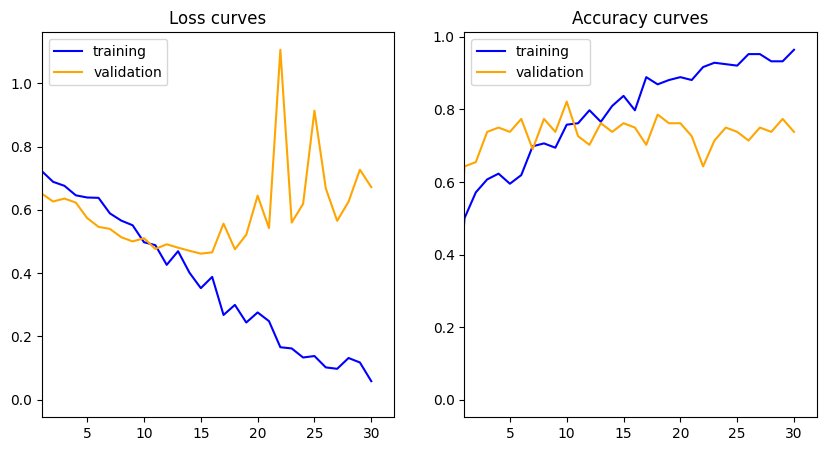

In [22]:
vgg19_model_1 = build_model(arch='vgg19', pretrained=True)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(vgg19_model_1.parameters(), lr=learning_rate)
num_epochs = 30
vgg19_model_1 = train_classifier(model=vgg19_model_1,
                                 model_name='vgg19_model_1',
                                 train_loader=train_dl,
                                 valid_loader=test_dl,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 num_epochs=num_epochs,
                                 plot_curves=True)

# 6. Evaluation

## 6.1. Concepts

- `model.eval()` is used to set the model to evaluation mode. This is done before testing a model. On the other hand, `model.train()` is used to set the model to training mode before training it.

- The data for testing is provided by a PyTorch data loader. It gives a batch of data each time it's called. A batch may contain different samples, but over a complete iteration (or 'epoch'), all test samples should be returned. The data loader we're using is a MONAI dictionary-type, so we can get the image data and labels from each batch using `batch['image']` and `batch['label']`.

- To speed up the testing process, we use a GPU if available. We send our images and labels data to the GPU using the `to(device)` command. This doesn't require any other changes to the code, which is a great advantage of PyTorch!

- The line `preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)` is used to get the model's predictions. The model's output is a vector with two values because we assigned two nodes to the final layer of our model. These values are transformed by the softmax function so that they add up to 1, making them meaningful for training and inference.

 <br><img src="https://i.ibb.co/JCPxvzJ/img5.jpg" alt="img5" border="0" height="100"><u><br>

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

@deterministic
def evaluate_model(model: Callable,
                   test_loader: Iterable = test_dl,
                   plot_cm: bool = True) -> float:
    """
    Evaluate a given model's performance on the test set.
    Parameters:
        model (Callable): the pytorch model to be evaluated.
        test_loader (Iterable): test dataloader to be used as the test data.
        plot_cm (bool): whether or not to plot a confusion matrix.
        accuracy (float): accuracy of the model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    labels_list = list()
    preds_list = list()
    with torch.no_grad():
        for batch in tqdm(test_dl):
            inputs, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            labels_list.append(labels)
            preds_list.append(preds)
        all_labels = torch.cat(labels_list).cpu()
        all_preds = torch.cat(preds_list).cpu()
        accuracy = (all_preds == all_labels).sum().item()/len(all_labels)

    if plot_cm:
        cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
        ax = plt.subplot()
        sns.heatmap(cm, annot=True, fmt='g', ax=ax)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(f'Confusion Matrix - accuracy: {accuracy:.2f}')
        ax.xaxis.set_ticklabels(['Glaucoma', 'Normal'])
        ax.yaxis.set_ticklabels(['Glaucoma', 'Normal'])

    return accuracy

  0%|          | 0/11 [00:00<?, ?it/s]

0.7619047619047619

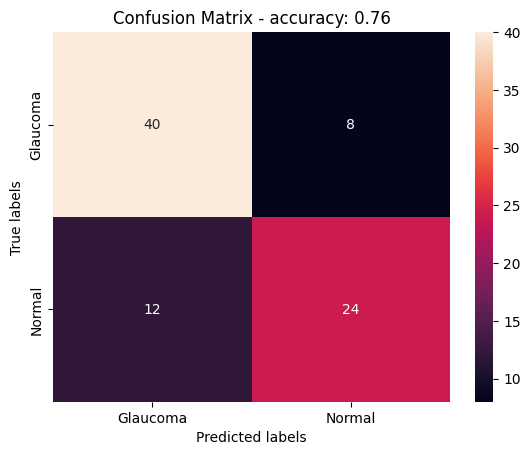

In [24]:
evaluate_model(vgg19_model_1)

## 6.2. Fitting

### 6.2.1. Concept
Whenever we train a regression model, we are trying to find a curve in a multidimensional space where most of our data points fall on or very close to this curve. Speaking more simply, a **fit** model is nothing different from a **well-trained** model. Unlike a well-fit (or well-trained) model, an **underfit** model has not learned enough from the training data. The curve from such a model will not cross as many data points as a well-trained model in the same poly-dimensional space.
On the other hand, an **overfit** model is a model that has learned more than necessary (e.g. the specific examples, not the overall idea) from the training data and will therefore not generalize well to the unseen data (e.g., the validation data). The mathematical representation for such a model is a curve that crosses almost all of the data points in the poly-dimensional space, even the outlier data points, which a well-trained model should ignore naturally. 

#### In the figure below: 
- The first row of the figure shows under-fitting, appropriate-fitting, and over-fitting for a regression problem
- The second row denotes the same concepts for a classification problem.

<br><img src="https://i.ibb.co/JQfKTDQ/img13.png" alt="img13" border="0" height="200"><u><br>

### 6.2.1. Standard training strategy

Although not always true, we generally train a neural network by pursuing the following three steps:

1.   Train a model to the point where it clearly is overfitting. As a general rule of thumb, every deep learning model will overfit the data if the training is continued long enough. In other words, if the model is not overfitting after an 'infinite' number of epochs, then something is probably not right in the training setup (data, model architecture, etc.). We will discuss a few of these scenarios below. On the other hand, it is also undesirable if a model overfits after just a few epochs. This warns us that the model might not have learned enough from the data. Again, this is something that we should be able to deal with.

2.   When overfitting starts, we can use different techniques to postpone it. For example, suppose the initial overfitting happens at epoch=10 for training. In that case, we do our best to postpone it so that it now happens a few epochs later, hoping that will improve its generalizability and ability to learn more meaningful features.

3.   Finally, one should save the version of our model's parameters that were in place around the time the model started to overfit. Practically, we do not usually pick the model the exact moment the overfitting started but choose our model from around that point and based on a desirable metric (e.g., accuracy). For example, if the model started to overfit at epoch 10, we may check epochs 9 to 11 and pick the model from either of these epochs which have the highest accuracy. This will ensure that we have a model that is not overfitting to our data and meets our expectations about metrics we care about.


---


> **Note**: Remember that the usual way to detect overfitting is from the loss curves. Overfitting starts when the training loss is still decreasing, but the validation loss is clearly increasing (some jitter is normal due to noise). If you look at the following image as an example, the red dashed line denotes where the overfitting starts, and the yellow area may be where we prefer to pick our final model from. And also in our model it occurs around `epoch=13`. Some data scientists prefer to end their training when they hit a checkpoint like the red dashed line below. That approach is called "early stopping" and may help consume less training resources (e.g., GPU).


---

<br><img src="https://i.ibb.co/DM24nwD/img14.png" alt="img14" border="0" height="400"><u><br>
 
 ---
 
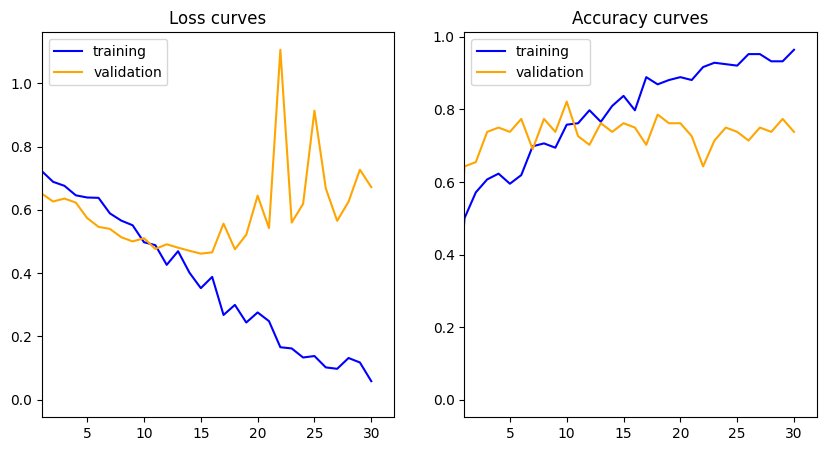

## 6.3. Under-fitting

If the training process never displays overfitting, the model is probably underfit. Even if the model's performance looks good, you should still find out why it is underfitting and address it since there may still be room for improving the model's performance. In the case of underfitting, there are three aspects we should check first in our training session: the training length, learning rate, and the architecture of the model.

### 6.3.1. Number of epochs

As mentioned before, one of the most common reasons for underfitting is that the model was not trained long enough. Look at the training session where we trained vgg16_model_1. You see that the model's performance at the end of the first epoch was not as good as the final model we saved in the later epochs. The reason is apparent. At the end of the first epoch, the model had not had the chance to learn enough signals from the data.
Addressing this form of underfitting is easy. Just let your model train longer. Do not forget our general rule of thumb that a model should be trained until it overfits the data.

### 6.3.2. Learning rate adjustment

A second reason for underfitting is using learning rates that are too small, which results in slower learning. The following code snippet shows this phenomenon by training our model for three epochs and using a minimal learning rate. You should see that the model is not learning significantly during this training and, therefore, will not appropriately fit the training data.

### 6.3.3. Architecture selection

The third common reason for underfitting is using a model that does not have enough capacity to learn the concept you desire from the data. For example, a linear model with a single layer of nodes will probably not have enough parameters to learn from the CXR data we have here.

---

## 6.4. Overfitting

Although underfitting may happen for the reasons mentioned above, the problem that is much more commonly seen during the training sessions is overfitting. As mentioned above, we always want to postpone overfitting as much as possible to give our model more time to learn from the data and improve its generalizability. Here, we will review four aspects of the training setup. Investigating and improving these may help with combatting overfitting. At the end of this section, we will deploy several of these strategies to run another round of training, with hopefully, more resistance to overfitting.

### 6.4.1. Training data size
It may look trivial, but we should mention that the most potent way for addressing overfitting is to add more data to your training. When oour model sees more data during the training, it will have a more difficult job to memorize all data. Instead, it will have a higher chance of learning the patterns present in the data. As we can imagine, the problem with this solution is that finding more data is often not very feasible.

### 6.4.2. Data augmentation

Data augmentation is a well-known strategy to combat overfitting. Although this technique is never as effective as adding more unique training data, it will still help the training. The fundamental advantage of data augmentation is that the model will see variations of data points in each epoch. For example, a single photo may be used in a slightly rotated, horizontally or vertically flipped, zoomed in or out, or brighter or darker variations when the data loader calls it in each epoch.

Although the list of possible augmentations for imaging data is very long (and newer techniques are introduced every day), there are two challenges that data scientists should consider when augmenting medical images:

1.   The first issue is to decide about which augmentations to use. Not all augmentations may make sense for medical images, and some may make the model's job harder for no reason. For example, in a scenario for classifying CXRs, it does not make sense to augment the CXRs by vertical flipping. The reason is that CXRs would never be acquired upside-down!

2.   The second challenge is how much to augment. For example, it may make sense to rotate the CXRs for a few degrees to make the model think these CXRs are new data. However, if we rotate them as much as 90 degrees, we will be in the same situation as described above, where the augmentation has no value. Even if such limitations do not exist, estimating the benefit of augmentation is difficult. In fact, the types and amount of augmentation is another hyperparameter one needs to tune to achieve a good fit.

---


>**Note**: As an exception to the above scenarios, if a CXR classifier is expected to see non-standard CXRs during the inference time (e.g., flipped or highly rotated ones), it may make sense to add such augmentations to our pipeline. Please note that augmenting the training data adds complexity to the model's data and makes the model fit more computationally demanding, so this complexity must have some returns (e.g., delayed overfitting).


---
<br>


### 6.4.3. Regularization

In simple words, regularization is focused on preventing a model from relying too much on any one of its parameters for making a prediction. To clarify, relying too much on any one parameter means that the value of that parameter gets too large, and therefore, that parameter will play a vital role in changing a model's decision. The intuition behind this theory is that if one or a few parameters have large values within a model, then the model is probably overfitting to those features. For example, suppose we want to train a model to differentiate CXRs for COVID19 patients with good prognosis from CXRs for COVID19 patients with poor prognosis. In that case, a suboptimal model may make predictions based on the presence or absence of a tracheal tube in the image (which is more common in poor prognosis patients but not always a prognosis determining factor) rather than relying on the lung tissue. In such a case, the weights responsible for detecting the features of a tracheal tube within the network may be much larger than other weights. Thus, whenever a tracheal tube is in the image field, the model will likely predict a poor prognosis. In summary, the purpose of regularization is to prevent such weights from getting too large!

#### L2 Regularization or Weight Decay
The idea of weight decay is simple: we penalize the weights that are large and force them towards zero (though they never become zero since this penalty declines as it approaches 0):


<br><img src="https://i.ibb.co/CVCsFJn/img15.png" alt="img15" border="0" height="200"><u><br>Cross-entropy loss with L2 regularization (weight decay)</u>
</br><br>

As shown above, a new term is added to the loss function, called L2. The higher the model's weights are, the higher the L2 will be, and thus, the overall loss. Here, lambda() is a hyperparameter to tune and determine how much penalty a model should receive from weight decay.

Fortunately, implementing weight decay in PyTorch is very simple. We only need to pass the lambda value to the optimizer class when building our optimizer. Then PyTorch will automatically implement that during the training:

```python
optimizer = torch.optim.SGD(vgg19_model_1.parameters(), lr=learning_rate, weight_decay=0.001)
```

In most cases, start with a value between 0.01 or 0.001 for lambda and gradually try larger or smaller values to find the optimal contribution of L2.


### 6.4.4. Architecture selection

From the discussion above, we can see that the more parameters a model has, the greater the tendency for overfitting. Imagine such a model as a smart but lazy student. It will learn the easiest way to solve the riddle of training data. If that is possible by simply memorizing all the data points you have, it might perform even better without having to learn the underlying principles.

The challenge is knowing what that right size is. The question of how big a model should be is, again, a matter of experimenting. A common strategy is to start with a model that worked well on a 'similar' problem, and if it overfits quickly, then reduce complexity and if it underfits, increase complexity. Repeat until satisfactory results are found.

Another important point to mention is that smaller models are not 'dumb' nor more challenging to train. Yes, they have lower capacity, but they may perform better than a more complex model!


### 6.4.5. Transfer learning and fine-tuning

Last but not least, **transfer learning** is one of the best techniques to reduce overfitting. Not only does it help with a better fit, but it also reduces the dependency of training on training data. This means, with appropriate deployment of transfer learning, the model may learn the same or even better with a smaller fraction of data at hand. This is very useful in fields like medicine when adding more data is not always feasible.

Each deep learning model is a huge mathematical equation with many parameters. These parameters often begin with random values when the model is created. In transfer learning, these parameters are not randomly initiated anymore. Instead, they are imported from another model already trained to do a task similar to what we pursue. This source model is called a "pre-trained" model.

Imagine our VGG19 model to classify the fondus images, and suppose we already have access to another VGG19 model that others have trained to differentiate diabetic retinopathy from normal. Although this second model is not exactly doing what we want to do, it is doing something similar, and perhaps, it will use many features that are similar to the features that our model should learn. In mathematical terms, many parameters of our model will probably end up having values close to values of the second model's parameters. Therefore, if one starts with this second model and starts to train that for the new purpose, training will probably be much faster and smoother than when training a randomly-initiated model from scratch. This process of just updating weights rather than training from random values is called **"fine-tuning."**

<br><img src="https://i.ibb.co/ck0tQt6/img16.png" alt="img16" border="0" height="200"><u><br>

It is not always possible to find a model that does a 'similar task' but it is often the case that transfer learning from a model that is fairly different can still be better than starting from random values. The good news is that there are a number of pre-trained models (e.g. the ImageNet database) for a variety of purposes that can be very useful for transfer learning, and if you have limited data, it is valuable to start with one of those models.

According to Wikipedia, The ImageNet project is a large visual database designed for use in visual object recognition software research. It consists of more than 14 million images of natural (not medical) objects that have been hand-annotated by the project to indicate what objects are pictured. As a tradition, whenever well-known deep learning models are introduced, developers pre-train them on ImageNet and release their weights. This means in the worst-case scenario, you can find access to the weights of a standard model that has been pre-trained on ImageNet to use in your project (unless you aim to use a custom architecture of your own or others). Although ImageNet is not a medical database, transfer learning from it to medical tasks is better than no transfer learning in many cases. The reason is that the ImageNet database is huge. Therefore, models pre-trained on that will have a memory of many features, at least some of which may be useful for medical training sessions as well.

In [25]:
# Defining a function to freeze the resnet models for fine-tunning

def freeze_resnet18(resnet18_model: Callable,
                    children_num_to_freeze: int = 5,
                    print_children: bool = False):
    """
    Freeze a resnet18 model up to a user-specified children module.
    Parameters:
    resnet18_model: The resnet18 model to be frozen and returned.
    children_num_to_freeze: The number of children modules to be frozen.
    print_children (bool): Whether or not to print the children modules.
    """
    for i, child in enumerate(resnet18_model.children()):
        if i < children_num_to_freeze:
            status = 'Frozen'
            for param in child.parameters():
                param.requires_grad = False
        else:
            status = 'Unfrozen'
        for param in child.parameters():
            param.requires_grad = True
            
        if print_children:
            print(f'******************* child module number: {i} - {status}')
            print(child)
    return resnet18_model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


-------------------- 
Starting epoch: 1/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.72 |         train accuracy: 0.61
valid loss: 0.86 |         valid accuracy: 0.60
-------------------- 
Starting epoch: 2/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.63 |         train accuracy: 0.65
valid loss: 0.59 |         valid accuracy: 0.64
-------------------- 
Starting epoch: 3/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.52 |         train accuracy: 0.74
valid loss: 0.50 |         valid accuracy: 0.77
-------------------- 
Starting epoch: 4/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.26 |         train accuracy: 0.87
valid loss: 0.67 |         valid accuracy: 0.71
-------------------- 
Starting epoch: 5/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.49 |         train accuracy: 0.77
valid loss: 0.60 |         valid accuracy: 0.71
-------------------- 
Starting epoch: 6/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.28 |         train accuracy: 0.87
valid loss: 0.67 |         valid accuracy: 0.70
-------------------- 
Starting epoch: 7/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.17 |         train accuracy: 0.90
valid loss: 0.63 |         valid accuracy: 0.76
-------------------- 
Starting epoch: 8/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.16 |         train accuracy: 0.91
valid loss: 0.77 |         valid accuracy: 0.77
-------------------- 
Starting epoch: 9/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.21 |         train accuracy: 0.90
valid loss: 0.79 |         valid accuracy: 0.73
-------------------- 
Starting epoch: 10/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.12 |         train accuracy: 0.94
valid loss: 0.60 |         valid accuracy: 0.71
-------------------- 
Starting epoch: 11/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.09 |         train accuracy: 0.95
valid loss: 0.80 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 12/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.15 |         train accuracy: 0.93
valid loss: 0.78 |         valid accuracy: 0.76
-------------------- 
Starting epoch: 13/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.09 |         train accuracy: 0.94
valid loss: 0.70 |         valid accuracy: 0.71
-------------------- 
Starting epoch: 14/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.23 |         train accuracy: 0.90
valid loss: 0.93 |         valid accuracy: 0.69
-------------------- 
Starting epoch: 15/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.27 |         train accuracy: 0.89
valid loss: 0.74 |         valid accuracy: 0.71
-------------------- 
Starting epoch: 16/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.14 |         train accuracy: 0.94
valid loss: 0.96 |         valid accuracy: 0.74
-------------------- 
Starting epoch: 17/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.08 |         train accuracy: 0.96
valid loss: 0.82 |         valid accuracy: 0.74
-------------------- 
Starting epoch: 18/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.08 |         train accuracy: 0.95
valid loss: 0.76 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 19/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.01 |         train accuracy: 0.98
valid loss: 0.80 |         valid accuracy: 0.73
-------------------- 
Starting epoch: 20/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.05 |         train accuracy: 0.97
valid loss: 0.83 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 21/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.17 |         train accuracy: 0.92
valid loss: 1.32 |         valid accuracy: 0.63
-------------------- 
Starting epoch: 22/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.05 |         train accuracy: 0.97
valid loss: 0.86 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 23/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.05 |         train accuracy: 0.96
valid loss: 0.94 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 24/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.09 |         train accuracy: 0.94
valid loss: 0.81 |         valid accuracy: 0.77
-------------------- 
Starting epoch: 25/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.10 |         train accuracy: 0.96
valid loss: 0.77 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 26/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.06 |         train accuracy: 0.96
valid loss: 0.90 |         valid accuracy: 0.76
-------------------- 
Starting epoch: 27/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.13 |         train accuracy: 0.94
valid loss: 0.81 |         valid accuracy: 0.75
-------------------- 
Starting epoch: 28/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.16 |         train accuracy: 0.93
valid loss: 1.39 |         valid accuracy: 0.60
-------------------- 
Starting epoch: 29/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.17 |         train accuracy: 0.94
valid loss: 0.86 |         valid accuracy: 0.74
-------------------- 
Starting epoch: 30/30


  0%|          | 0/31 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

train loss: 0.14 |         train accuracy: 0.94
valid loss: 0.82 |         valid accuracy: 0.73

Training was over. The best model was: resnet18_model_2_Epoch3_ACC=0.7738095238095238.pth


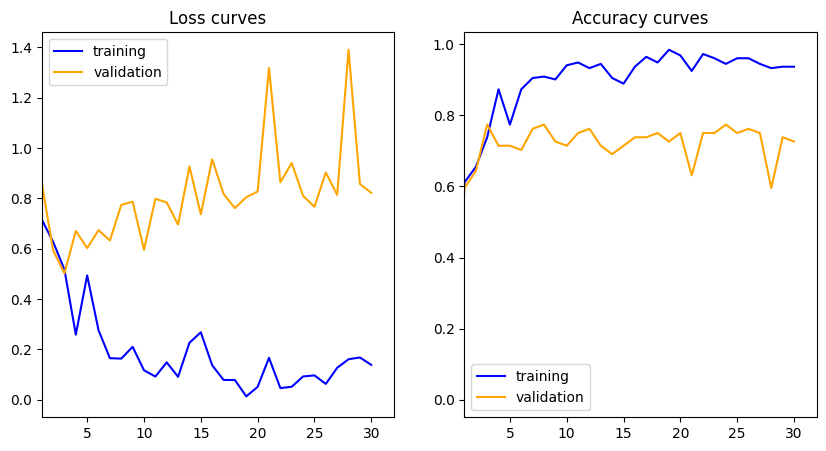

In [26]:
resnet18_model = build_model(arch='resnet18', pretrained=True)
resnet18_model = freeze_resnet18(resnet18_model,
                                   children_num_to_freeze = 5,
                                   print_children=False)


criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=learning_rate,
                            weight_decay=0.001)
num_epochs = 30
resnet18_model_2 = train_classifier(model=resnet18_model,
                                 model_name='resnet18_model_2',
                                 train_loader=train_dl,
                                 valid_loader=test_dl,
                                 criterion=criterion,
                                 optimizer=optimizer,
                                 num_epochs=num_epochs,
                                 plot_curves=True)

  0%|          | 0/11 [00:00<?, ?it/s]

0.7738095238095238

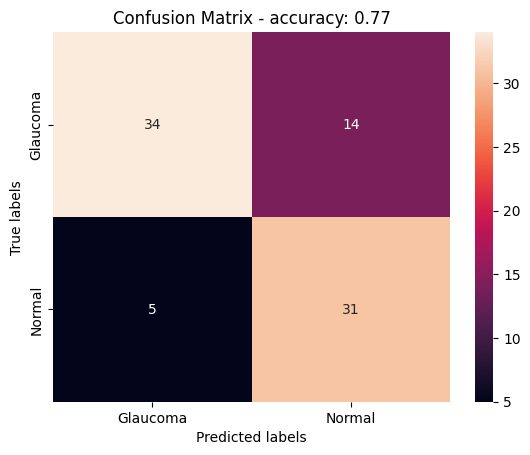

In [27]:
evaluate_model(resnet18_model_2)

# 7. Acknowledgements

I would like to express my gratitude to the authors of the referenced notebook for their valuable information and insights. Their work greatly contributed to the development of this notebook. You can find the original notebook here:
[Authors: Pouria Rouzrokh, MD, MPH, MHPE; Bardia Khosravi, MD, MPH, MHPE](https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/MIDeL/blob/main/chapters/9A.ipynb#scrollTo=83Up5jCrSPQD)

Thank you!